# Data Science Challenge

The dataset provided consists of examples of data points we often use to solve business problems. Data Scientists who sit with our product teams are typically tasked with understanding our user behaviour. Usually, we are concerned with engagement and churn. Utilizing this data, your business knowledge and potentially your interests, answer the following questions.

A.) Define a target metric to measure user engagement. How would you define an engaged vs. unengaged user? 

B.) Using your logic from above, build a model (heuristic/statistical/ML) to classify engaged and unengaged users. Note that features which are directly correlated with your target metric could lead to overfitting.

C.) Let’s assume an unengaged user is a churned user. Now suppose we use your model to identify unengaged users and implement some business actions try to convert them to engaged users (commonly known as reducing churn). How would you set up a test/experiment to check whether we are actually reducing churn?

D.) In the past, one business action we took to reduce churn was to re-engage inactive users. Our engagement team designed a marketing campaign, REENGAGEMENT_ACTIVE_FUNDS to remind inactive users about funds on their account. Define a metric to measure the effectiveness of the campaign. Under this metric, was the campaign effective?


In [81]:
# import libraries
import pandas as pd
import psycopg2 as pg 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sys, os
import pandas.io.sql as psql
import datetime 
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

In [82]:
sns.set(color_codes=True)


In [84]:
host='178.62.46.127'
port=54320
dbname='ht_db'
user='postgres'

In [85]:
# func to create DB connections
def create_connection():
    try:
        connection = pg.connect(
            host=host,
            port=port,
            dbname=dbname,
            user=user
        )
    except (Exception, psycopg2.Error) as error :
        print ("Error while fetching data from PostgreSQL", error)
    return connection

# func to close a connection
def close_connection(connection: pg.extensions.connection):
    connection.close()
    print("PostgreSQL connection is closed")

    
def load_data(schema, table, conn):

    sql_command = "SELECT * FROM {}.{};".format(str(schema), str(table))
    print (sql_command)

    # Load the data
    data = pd.read_sql(sql_command, conn)

    print(data.shape)
    return (data)




## Data Investigation 

Pulling transcations and users info and doing some exploratory data investigation

In [86]:
#create connection to db
connection=create_connection()

In [87]:
# get users
df_users = load_data(schema="public",table="users",conn=connection)
df_users.head()


SELECT * FROM public.users;
(19430, 12)


,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,NaN,NaN,21,0,0
2,user_2,1987,PL,Poznań,2018-01-18 19:17:31.229096,0,STANDARD,0.0,0.0,21,0,0
3,user_3,1994,FR,Paris,2018-01-15 18:47:56.723104,0,STANDARD,1.0,0.0,0,0,0
4,user_4,1985,GB,Beckenham,2018-01-11 00:36:46.673673,0,STANDARD,NaN,NaN,2,0,0


In [88]:
# get transcations
df_transc = load_data(schema="public",table="transactions",conn=connection)
df_transc.head()

SELECT * FROM public.transactions;
(2740075, 12)


,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,None,NaN,None,None,OUTBOUND,user_898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-19 06:15:59.537032
2,transaction_2,CARD_PAYMENT,AED,43.40,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-18 18:53:41.323032
3,transaction_3,TRANSFER,AED,10043.01,COMPLETED,None,NaN,None,None,OUTBOUND,user_1652,2019-03-22 14:20:01.513032
4,transaction_4,CARD_PAYMENT,AED,43.81,COMPLETED,FALSE,5651.0,Abu Dhabi,ARE,OUTBOUND,user_5509,2019-03-22 05:42:50.316652


Merging datasets together and then aggregating the dataset to look for trends

In [89]:
df = pd.merge(df_users, df_transc, on='user_id')


In [90]:
df.head()

,user_id,birth_year,country,city,created_date_x,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,...,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,created_date_y
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,EXCHANGE,GBP,2.12,COMPLETED,None,NaN,None,None,OUTBOUND,2018-06-19 01:36:43.065466
1,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,EXCHANGE,SGD,27.90,COMPLETED,None,NaN,None,None,OUTBOUND,2018-06-25 03:51:25.977466
2,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,CARD_PAYMENT,USD,8.34,COMPLETED,TRUE,7372.0,1760483369,USA,OUTBOUND,2018-06-19 01:39:43.741466
3,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,CARD_PAYMENT,USD,182.17,COMPLETED,TRUE,8398.0,Lahore,PAK,OUTBOUND,2018-08-04 00:45:28.893466
4,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,CARD_PAYMENT,USD,0.00,REVERTED,FALSE,5968.0,888-283-5051,USA,OUTBOUND,2019-01-25 11:07:06.359466


### Errors in the data?

Potentially some erronerous or false records - with the majority of the records being less than $100 but some transcations being over a billion

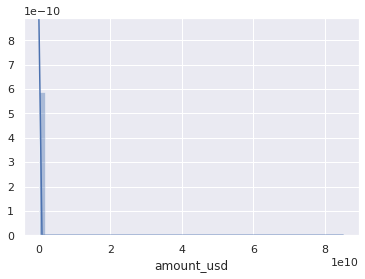

In [91]:
sns.distplot(df.amount_usd);

count    2.740075e+06
mean     1.703225e+05
std      9.634014e+07
min      0.000000e+00
25%      2.030000e+00
50%      8.510000e+00
75%      2.822000e+01
max      8.510645e+10
Name: amount_usd, dtype: float64
55


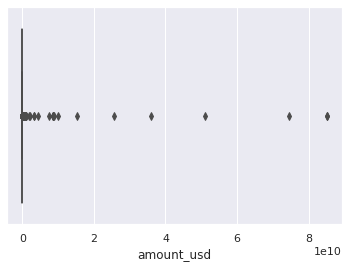

In [92]:
print(df.amount_usd.describe())
print(df[df.amount_usd >= 1e+08].amount_usd.count())
sns.boxplot(x=df['amount_usd'])

In [93]:
df[df.amount_usd > 1e10].head()

,user_id,birth_year,country,city,created_date_x,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,...,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,created_date_y
384921,user_1931,1991,PL,Podłęże,2018-02-08 09:49:03.190937,0,STANDARD,NaN,NaN,22,...,TRANSFER,EUR,8.510645e+10,DECLINED,None,NaN,None,None,OUTBOUND,2019-04-06 10:17:16.384937
570389,user_2997,1994,CH,Saxon,2018-03-25 11:47:29.938049,1,PREMIUM,NaN,NaN,3,...,TRANSFER,CHF,7.464155e+10,DECLINED,None,NaN,None,None,OUTBOUND,2018-12-30 02:42:55.598049
857659,user_4565,1989,IE,Dublin,2018-04-04 00:42:13.969329,0,STANDARD,1.0,0.0,58,...,TRANSFER,EUR,8.510645e+10,DECLINED,None,NaN,None,None,OUTBOUND,2019-03-30 21:21:27.904329
1050192,user_5694,1984,GB,London,2018-05-30 15:25:46.477038,0,STANDARD,1.0,1.0,322,...,TRANSFER,GBP,3.600000e+10,DECLINED,None,NaN,None,None,OUTBOUND,2019-03-16 15:22:46.076038
1839361,user_10608,1988,MT,Hamrun,2018-08-24 09:16:23.154829,0,STANDARD,NaN,NaN,70,...,TRANSFER,EUR,2.553194e+10,DECLINED,None,NaN,None,None,OUTBOUND,2018-12-06 22:36:36.758829


In [94]:
df.transactions_state.unique()

array(['COMPLETED', 'REVERTED', 'DECLINED', 'FAILED', 'CANCELLED',
       'PENDING'], dtype=object)

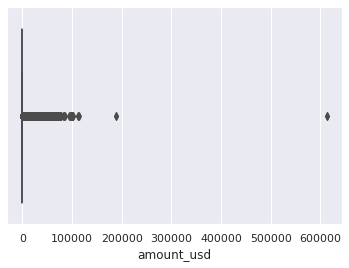

In [95]:
sns.boxplot(x=df[df.transactions_state == 'COMPLETED'].amount_usd)


## Question A.) 

Question: Define a target metric to measure user engagement. How would you define an engaged vs. unengaged user?

Answer: there are four metrics which I think would have a significant impact for user engagement (listed below). However, in the analysis below, I think the most significatn target metric looks like the time since last transcation or either a combination of the below metrics

* i.) frequency of transcations
* ii.) time since last transcation
* iii.) time since joining
* iv.) average spending amount 

Assumptions:
* i.) Users who are spending more frequently are probably more likely to be engaged with the product
* ii.) Similarly, users who haven't made a transcation for awhile may not be engaged anymore
* iii.) I imagine the longer the user has been there, the more likely they are to churn
* iv.) The average spending on transcations might indicate that users are engaged if they have higher than average spending averages as the are committed to higher purchases or more frequent purchases
    


In [96]:
def summarise_dataset(df):
    """
    
    """
    df_summarise = df[df.transactions_state == 'COMPLETED'].groupby('user_id').agg({
        # each user's total spend, mean spend, frequency, time of most recent transaction
        "amount_usd": {
             "amount_usd_total": "sum", 
             "amount_usd_mean": "mean",
             "frequency_spend": "count"
        },
        "created_date_y": {
            "min_transcation_date": "min",
            "max_transcation_date": "max"
        },
        "created_date_x": {
            "created_date": "min"
        }
       
    })

    df_summarise['time_since_last_transcation'] = (end_day-df_summarise.created_date_y.max_transcation_date).astype('timedelta64[D]')
    df_summarise['time_since_start'] = (df_summarise.created_date_y.max_transcation_date-df_summarise.created_date_x.created_date).astype('timedelta64[D]')
    df_summarise['time_since_first_transcation'] = (df_summarise.created_date_y.max_transcation_date-df_summarise.created_date_y.min_transcation_date).astype('timedelta64[D]')
    return df_summarise


In [97]:
# only taking into account transcations which have completed in the analysis

end_day = max(df.created_date_y)

df_sum = summarise_dataset(df)
df_sum.head()

/root/revolut/my_project_env/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


amount_usd                                  \
          amount_usd_total amount_usd_mean frequency_spend   
user_id                                                      
user_0            12648.60       36.138857             350   
user_1             5705.35       50.046930             114   
user_10           24508.38       28.969716             846   
user_100          16106.18      146.419818             110   
user_1000         20128.31      575.094571              35   

                      created_date_y                             \
                min_transcation_date       max_transcation_date   
user_id                                                           
user_0    2018-01-16 23:24:18.666466 2019-05-02 03:38:44.690466   
user_1    2018-01-31 09:13:58.795876 2019-02-24 21:25:15.962876   
user_10   2018-01-04 08:09:47.823282 2019-05-11 11:01:00.564282   
user_100  2018-01-15 16:39:14.747386 2019-05-07 13:00:24.319386   
user_1000 2018-01-06 14:26:51.752706 2018-06-26 05:00:42.236706   

                      created_date_x time_since_last_transcation  \
                        created_date                               
user_id                                                            
user_0    2018-01-13 05:15:15.599466                        14.0   
user_1    2018-01-29 03:38:46.676876                        80.0   
user_10   2018-01-04 08:05:15.466282                         5.0   
user_100  2018-01-15 08:42:17.099386                         9.0   
user_1000 2018-01-06 14:21:52.165706                       324.0   

          time_since_start time_since_first_transcation  
                                                         
user_id                                                  
user_0               473.0                        470.0  
user_1               391.0                        389.0  
user_10              492.0                        492.0  
user_100             477.0                        476.0  
user_1000            170.0                        170.0

(array([1.8513e+04, 9.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0.       ,  5338.8961875, 10677.792375 , 16016.6885625,
        21355.58475  , 26694.4809375, 32033.377125 , 37372.2733125,
        42711.1695   , 48050.0656875, 53388.961875 ]),
 <a list of 10 Patch objects>)

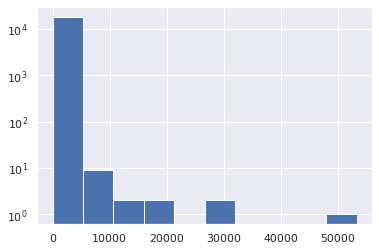

In [98]:
# distribution of average spend per customer
plt.hist(df_sum.amount_usd.amount_usd_mean, log=True) 

(array([1.8503e+04, 1.8000e+01, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([      0.   ,  320668.297,  641336.594,  962004.891, 1282673.188,
        1603341.485, 1924009.782, 2244678.079, 2565346.376, 2886014.673,
        3206682.97 ]),
 <a list of 10 Patch objects>)

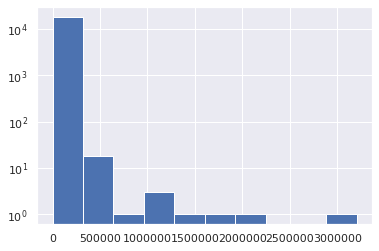

In [99]:
# distribution of total spend per customer
plt.hist(df_sum.amount_usd.amount_usd_total, log=True) 

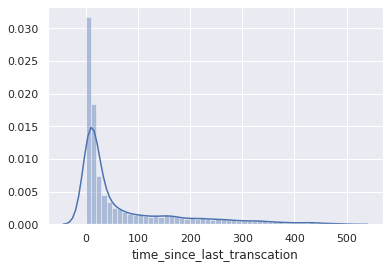

In [100]:
# distribution of days since last transcation
sns.distplot(df_sum.time_since_last_transcation);

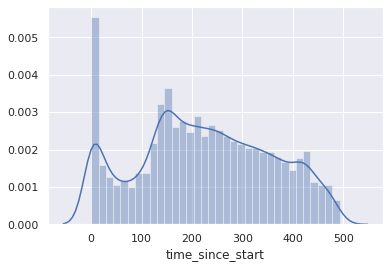

In [101]:
# distribution of days since creating an acct
sns.distplot(df_sum.time_since_start)

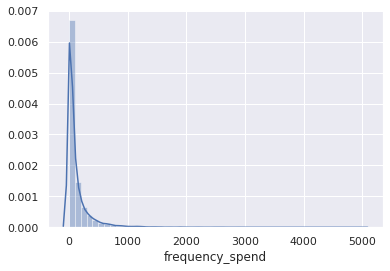

In [102]:
# distribution of frequency of transcations
sns.distplot(df_sum.amount_usd.frequency_spend)

## Question B.)

Question: Using your logic from above, build a model (heuristic/statistical/ML) to classify engaged and unengaged users. Note that features which are directly correlated with your target metric could lead to overfitting.

Answer: Looking at the df_sum dataset, there are quick methods we could perform to give us a view of engaged vs unengaged users - one being heuristic using the target metric above and the other clustering the customers using the four metrics mentioned above

#### Heuristic model
by applying a threshold of 50 days since the last transcation distribution. Everything to the left of the threshold would be the active users and everything to the right would be the inactive users

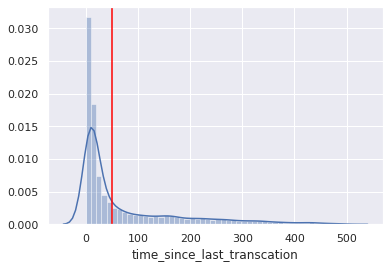

In [103]:
# set a threshold at 50 days
sns.distplot(df_sum.time_since_last_transcation)
plt.axvline(50, color='red')


In [104]:
df_sum.describe()

amount_usd                                  \
      amount_usd_total amount_usd_mean frequency_spend   
count     1.852900e+04    18529.000000    18529.000000   
mean      8.374985e+03       89.537569      129.956716   
std       4.192871e+04      602.553458      228.089532   
min       0.000000e+00        0.000000        1.000000   
25%       4.000000e+02       15.669118       13.000000   
50%       2.171360e+03       33.263171       50.000000   
75%       6.970300e+03       65.870000      143.000000   
max       3.206683e+06    53388.961875     4996.000000   

      time_since_last_transcation time_since_start  \
                                                     
count                18529.000000     18529.000000   
mean                    73.519240       224.679691   
std                    103.288898       131.927331   
min                      0.000000         0.000000   
25%                      7.000000       134.000000   
50%                     20.000000       220.000000   
75%                    102.000000       328.000000   
max                    497.000000       493.000000   

      time_since_first_transcation  
                                    
count                 18529.000000  
mean                    208.953047  
std                     132.660676  
min                       0.000000  
25%                     113.000000  
50%                     204.000000  
75%                     311.000000  
max                     493.000000

<function matplotlib.pyplot.show(*args, **kw)>

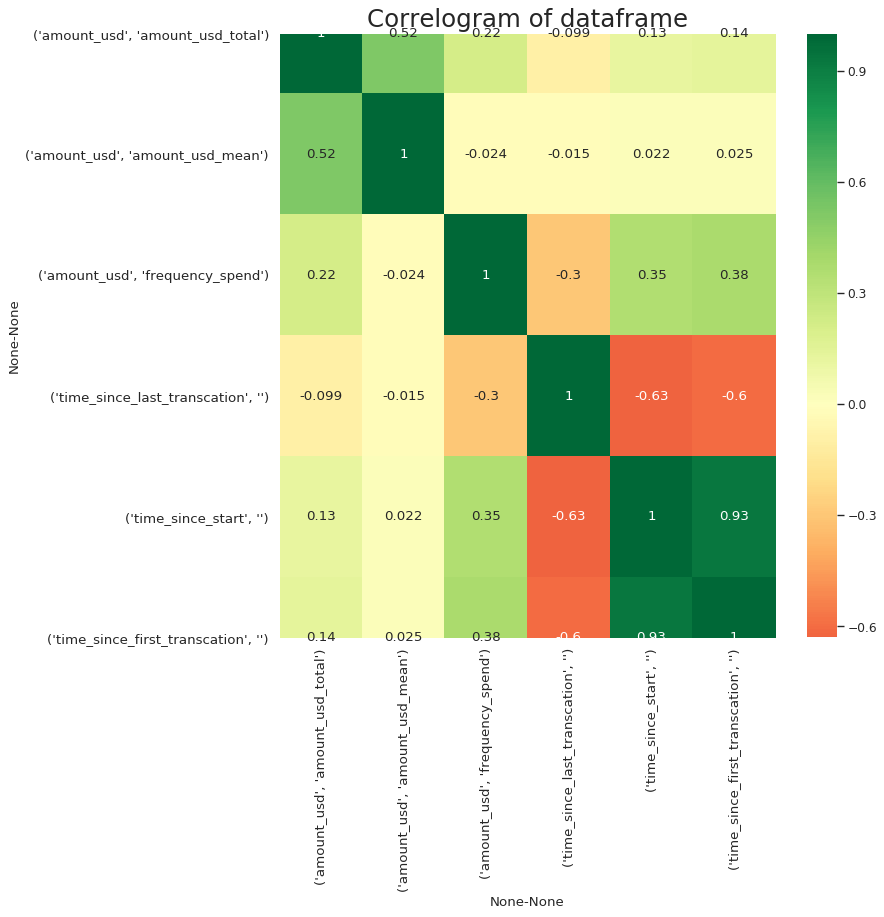

In [105]:
# Plot
plt.figure(figsize=(10,10), dpi= 80)
sns.heatmap(df_sum.corr(), xticklabels=df_sum.corr().columns, yticklabels=df_sum.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of dataframe', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show

In [106]:
df_sum.head()

amount_usd                                  \
          amount_usd_total amount_usd_mean frequency_spend   
user_id                                                      
user_0            12648.60       36.138857             350   
user_1             5705.35       50.046930             114   
user_10           24508.38       28.969716             846   
user_100          16106.18      146.419818             110   
user_1000         20128.31      575.094571              35   

                      created_date_y                             \
                min_transcation_date       max_transcation_date   
user_id                                                           
user_0    2018-01-16 23:24:18.666466 2019-05-02 03:38:44.690466   
user_1    2018-01-31 09:13:58.795876 2019-02-24 21:25:15.962876   
user_10   2018-01-04 08:09:47.823282 2019-05-11 11:01:00.564282   
user_100  2018-01-15 16:39:14.747386 2019-05-07 13:00:24.319386   
user_1000 2018-01-06 14:26:51.752706 2018-06-26 05:00:42.236706   

                      created_date_x time_since_last_transcation  \
                        created_date                               
user_id                                                            
user_0    2018-01-13 05:15:15.599466                        14.0   
user_1    2018-01-29 03:38:46.676876                        80.0   
user_10   2018-01-04 08:05:15.466282                         5.0   
user_100  2018-01-15 08:42:17.099386                         9.0   
user_1000 2018-01-06 14:21:52.165706                       324.0   

          time_since_start time_since_first_transcation  
                                                         
user_id                                                  
user_0               473.0                        470.0  
user_1               391.0                        389.0  
user_10              492.0                        492.0  
user_100             477.0                        476.0  
user_1000            170.0                        170.0

In [107]:
# get total spend, frequency, and time since last purchase
values = df_sum.iloc[:, [0, 2, 7, 8]].values

In [108]:
X = preprocessing.normalize(values)

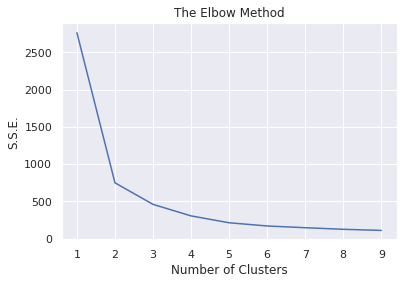

In [109]:
distortions = []
K = range(1, 10)
for k in K:
    kmeansModel = KMeans(n_clusters = k, init = 'k-means++', random_state = 23)
    kmeansModel.fit(X)
    distortions.append(kmeansModel.inertia_)
    
plt.plot(K, distortions)
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("S.S.E.")
plt.show()

### Looks like there is three possible clusters of users

In [110]:
kmeansModel = KMeans(n_clusters = 3, init = 'k-means++', random_state = 23)
kmeansModel.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=23, tol=0.0001, verbose=0)

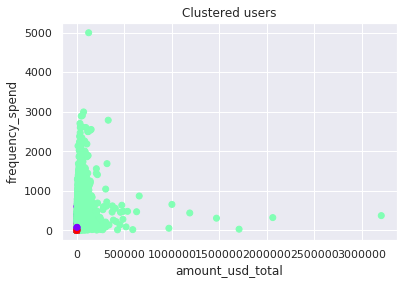

In [111]:
plt.scatter(values[:,0], values[:,1], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("amount_usd_total")
plt.ylabel("frequency_spend")
plt.show()


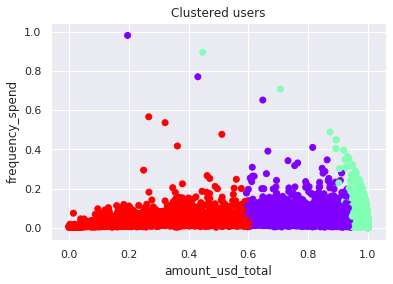

In [112]:
plt.scatter(X[:,0], X[:,1], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("amount_usd_total")
plt.ylabel("frequency_spend")
plt.show()

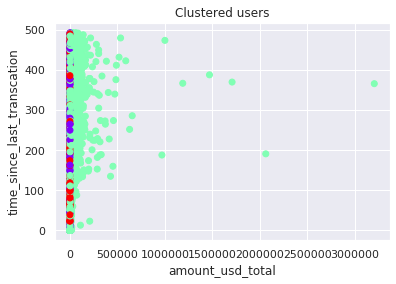

In [113]:
plt.scatter(values[:,0], values[:,2], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("amount_usd_total")
plt.ylabel("time_since_last_transcation")
plt.show()


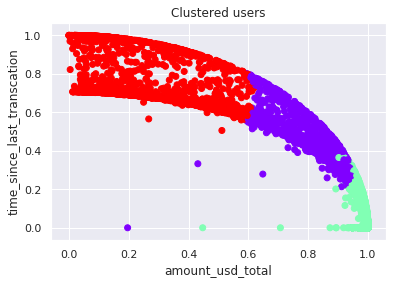

In [114]:
plt.scatter(X[:,0], X[:,2], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("amount_usd_total")
plt.ylabel("time_since_last_transcation")
plt.show()


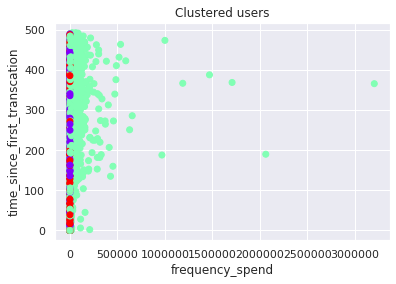

In [115]:
plt.scatter(values[:,0], values[:,3], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("frequency_spend")
plt.ylabel("time_since_first_transcation")
plt.show()

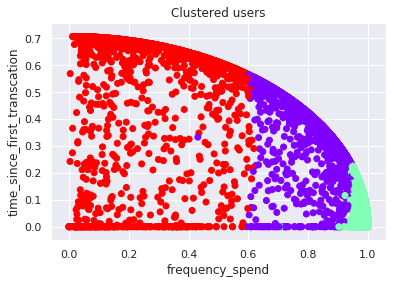

In [116]:
plt.scatter(X[:,0], X[:,3], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("frequency_spend")
plt.ylabel("time_since_first_transcation")
plt.show()


### Clustering into three groups

From the three groups, we can say that we can cluster customers into three buckets of light blue a.), purple b.) and red c.). 

* a.) Can be defined as users who are extremely engaged new users - high volumes of transcations, recently joined and have spend the most with their transcations. 
* b.) These users can be seen as having medium engagement - still relatively high volumes, however, they tend to have been a user for longer and similarly, it tends to be awhile since their last transcation. 
* c.) These are the unengaged users - they tend to have lower volumes of overall transcations, have spend overall less on those transcations and its been a long time since their last transcation. Lastly, they also seem have the widest range of users since their first transcation.

## Question C.)


Question: Let’s assume an unengaged user is a churned user. Now suppose we use your model to identify unengaged users and implement some business actions try to convert them to engaged users (commonly known as reducing churn). How would you set up a test/experiment to check whether we are actually reducing churn?

Answer: Lets say that the action to try and convert unengaged users was a push notification to their phones, one really interesting way to measure whether the action actually had any effect would be run a randomised a/b test as well as use cohort analysis to help get a full picture of both a macro and micro view.

To run an A/B test, you would first 
* Pick your target variable - i.e. whether users is engaged or not.
* Set up your hypothesis and null hypothesis - i.e. hypothesis is that it will lead to a 5% conversion of unengaged users to engaged users.
* Identify the total population of unengaged users and the size of the sample you would like to run in the experiment. 
* Then you would identify how long you would need to run the experiment from looking at the transcation volumes and determining a confidence interval you would be happy with.
* Determine a ranomised control group and an experiment group from the sample - who to send the users in the experiment group the push notification and dont send anything to the users in the other.
* Run the experiment for the entire period and then determine if the users in the control group have become more engaged using your target metrics.

The on a macro view, you could use the cohort in which you choose to run the experiment to determine how it develops over time. If there is a significant improvement in the retention within the cohort compare to the other cohorts then you will know that it is working.





In [117]:
df.head()

,user_id,birth_year,country,city,created_date_x,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,...,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,created_date_y
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,EXCHANGE,GBP,2.12,COMPLETED,None,NaN,None,None,OUTBOUND,2018-06-19 01:36:43.065466
1,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,EXCHANGE,SGD,27.90,COMPLETED,None,NaN,None,None,OUTBOUND,2018-06-25 03:51:25.977466
2,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,CARD_PAYMENT,USD,8.34,COMPLETED,TRUE,7372.0,1760483369,USA,OUTBOUND,2018-06-19 01:39:43.741466
3,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,CARD_PAYMENT,USD,182.17,COMPLETED,TRUE,8398.0,Lahore,PAK,OUTBOUND,2018-08-04 00:45:28.893466
4,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,CARD_PAYMENT,USD,0.00,REVERTED,FALSE,5968.0,888-283-5051,USA,OUTBOUND,2019-01-25 11:07:06.359466


In [118]:
df['transcation_month'] = df.created_date_y.apply(lambda x: x.strftime('%Y-%m'))


In [119]:
df.set_index('user_id', inplace=True)

df['CohortGroup'] = df.groupby(level=0)['created_date_y'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)
df.head()

,user_id,birth_year,country,city,created_date_x,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,...,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,created_date_y,transcation_month,CohortGroup
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,2.12,COMPLETED,None,NaN,None,None,OUTBOUND,2018-06-19 01:36:43.065466,2018-06,2018-01
1,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,27.90,COMPLETED,None,NaN,None,None,OUTBOUND,2018-06-25 03:51:25.977466,2018-06,2018-01
2,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,8.34,COMPLETED,TRUE,7372.0,1760483369,USA,OUTBOUND,2018-06-19 01:39:43.741466,2018-06,2018-01
3,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,182.17,COMPLETED,TRUE,8398.0,Lahore,PAK,OUTBOUND,2018-08-04 00:45:28.893466,2018-08,2018-01
4,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,0.00,REVERTED,FALSE,5968.0,888-283-5051,USA,OUTBOUND,2019-01-25 11:07:06.359466,2019-01,2018-01


In [120]:
grouped = df.groupby(['CohortGroup', 'transcation_month'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'transaction_id': pd.Series.nunique,
                       'amount_usd': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'user_id': 'TotalUsers',
                        'transaction_id': 'TotalTranscations'}, inplace=True)
cohorts.head()

TotalUsers  TotalTranscations  amount_usd
CohortGroup transcation_month                                           
2018-01     2018-01                   778               6248   905563.36
            2018-02                   533               8872  1261132.46
            2018-03                   501               9303   765091.23
            2018-04                   466               8754   900840.51
            2018-05                   457              10993   638872.89

In [121]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalTranscations  amount_usd  \
CohortGroup transcation_month                                              
2018-01     2018-01                   778               6248   905563.36   
            2018-02                   533               8872  1261132.46   
            2018-03                   501               9303   765091.23   
            2018-04                   466               8754   900840.51   
            2018-05                   457              10993   638872.89   

                               CohortPeriod  
CohortGroup transcation_month                
2018-01     2018-01                       1  
            2018-02                       2  
            2018-03                       3  
            2018-04                       4  
            2018-05                       5

In [122]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2018-01     778
2018-02     768
2018-03    1694
2018-04    1021
2018-05    1431
Name: TotalUsers, dtype: int64

In [123]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
CohortPeriod,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.685090,0.750000,0.619244,0.730656,0.709993,0.696950,0.744079,0.730861,0.728477,0.699269,0.706015,0.691968,0.679245,0.664516,0.681034,0.504854,NaN
3,0.643959,0.652344,0.602125,0.671890,0.661076,0.642313,0.646053,0.658493,0.662252,0.673974,0.662732,0.641218,0.674528,0.658065,0.500000,NaN,NaN
4,0.598972,0.630208,0.581464,0.626836,0.634521,0.603558,0.588816,0.640550,0.632751,0.653176,0.640809,0.632392,0.669811,0.470968,NaN,NaN,NaN
5,0.587404,0.613281,0.571429,0.617042,0.607268,0.573062,0.586842,0.622010,0.620710,0.620573,0.655987,0.619594,0.459906,NaN,NaN,NaN,NaN
6,0.595116,0.585938,0.589138,0.580803,0.592593,0.557814,0.585526,0.615431,0.615894,0.646431,0.647555,0.467343,NaN,NaN,NaN,NaN,NaN
7,0.584833,0.605469,0.582645,0.584721,0.573725,0.567980,0.576974,0.596890,0.636966,0.639685,0.487915,NaN,NaN,NaN,NaN,NaN,NaN
8,0.553985,0.608073,0.589728,0.585700,0.585604,0.557814,0.566447,0.626794,0.627333,0.505902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.541131,0.574219,0.583235,0.566112,0.565339,0.560356,0.598684,0.614234,0.490066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
user_retention.tail(10)

CohortGroup,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
CohortPeriod,,,,,,,,,,,,,,,,,
8,0.553985,0.608073,0.589728,0.585700,0.585604,0.557814,0.566447,0.626794,0.627333,0.505902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.541131,0.574219,0.583235,0.566112,0.565339,0.560356,0.598684,0.614234,0.490066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.528278,0.572917,0.586187,0.571988,0.574423,0.583227,0.614474,0.488636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.538560,0.567708,0.590909,0.554358,0.616352,0.580686,0.457895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.534704,0.582031,0.591499,0.598433,0.597484,0.453621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.542416,0.561198,0.603306,0.596474,0.465409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,0.542416,0.572917,0.599174,0.453477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,0.548843,0.580729,0.452184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.544987,0.472656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


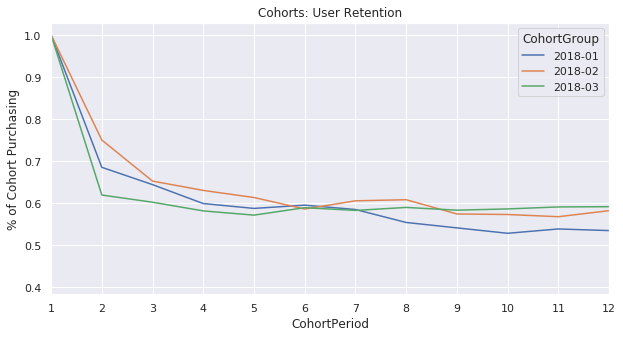

In [125]:
user_retention[['2018-01', '2018-02', '2018-03']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

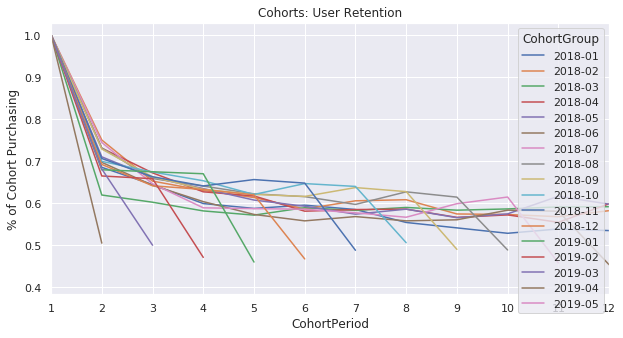

In [126]:
user_retention.plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

### Cohort Analysis

From the diagram above, the graph is showing how users are broken into cohorts from their first trancation, and how at the start of that cohort period most of the users make a transcation. However, overtime users in those cohorts slow drop out or dont make any more transcations. 

When rolling out the experiment, you could test overall engagement by monitoring changes in cohort behaviour to see if there is an incremental improvement over time. 

## Question D.)


In the past, one business action we took to reduce churn was to re-engage inactive users. Our engagement team designed a marketing campaign, REENGAGEMENT_ACTIVE_FUNDS to remind inactive users about funds on their account. Define a metric to measure the effectiveness of the campaign. Under this metric, was the campaign effective?

Answer: We will use the metric of an increase in time since last transcation as our metric. With the idea that users who are unengaged havent made a purchase over 50 days.  

More specifically, we'll investigate whether there is a change in the mean of days since the last purchase from the experiment group before the first REENGAGEMENT_ACTIVE_FUNDS campaign was sent out.

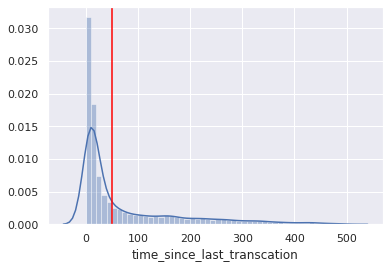

In [127]:
# set a threshold at 50 days
sns.distplot(df_sum.time_since_last_transcation)
plt.axvline(50, color='red')

In [128]:
df_not = load_data(schema="public",table="notifications",conn=connection)
df_not = df_not[df_not.reason == 'REENGAGEMENT_ACTIVE_FUNDS']
df_not.shape

SELECT * FROM public.notifications;
(121813, 5)


(35844, 5)

In [129]:
df_not.tail()

,reason,channel,status,user_id,created_date
114159,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_15744,2019-02-13 11:34:43.280997
114160,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_19400,2019-02-13 21:14:10.128829
114161,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_15419,2019-02-13 16:26:53.139015
114162,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_16684,2019-02-13 00:42:44.349263
114163,REENGAGEMENT_ACTIVE_FUNDS,PUSH,FAILED,user_10347,2019-02-14 05:58:49.667832


In [130]:
campaign_start_date = min(df_not.created_date)
print(campaign_start_date)

2018-08-03 20:19:29.049828


In [131]:
#filter out users who were in the campaign and then filter out any users who started before the experiment
df_camp = df[df.user_id.isin(df_not['user_id'].unique().tolist())]
df_camp = df_camp[df_camp.created_date_x < '2018-08-03 20:19:29.049828']
df_camp.head()
            

,user_id,birth_year,country,city,created_date_x,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,...,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,created_date_y,transcation_month,CohortGroup
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,2.12,COMPLETED,None,NaN,None,None,OUTBOUND,2018-06-19 01:36:43.065466,2018-06,2018-01
1,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,27.90,COMPLETED,None,NaN,None,None,OUTBOUND,2018-06-25 03:51:25.977466,2018-06,2018-01
2,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,8.34,COMPLETED,TRUE,7372.0,1760483369,USA,OUTBOUND,2018-06-19 01:39:43.741466,2018-06,2018-01
3,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,182.17,COMPLETED,TRUE,8398.0,Lahore,PAK,OUTBOUND,2018-08-04 00:45:28.893466,2018-08,2018-01
4,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,...,0.00,REVERTED,FALSE,5968.0,888-283-5051,USA,OUTBOUND,2019-01-25 11:07:06.359466,2019-01,2018-01


In [132]:
df_camp[df_camp.created_date_y >= '2018-08-03 20:19:29.049828'].describe()

,birth_year,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,amount_usd,ea_merchant_mcc
count,783212.000000,783212.000000,554352.000000,554352.000000,783212.000000,783212.0,783212.0,7.832120e+05,471640.000000
mean,1984.880996,0.304086,0.938905,0.895492,25.464014,0.0,0.0,3.017862e+05,5711.193540
std,10.064804,0.460020,0.239504,0.305918,63.463924,0.0,0.0,1.354368e+08,956.014354
min,1934.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00,742.000000
25%,1980.000000,0.000000,1.000000,1.000000,3.000000,0.0,0.0,2.550000e+00,5411.000000
50%,1987.000000,0.000000,1.000000,1.000000,11.000000,0.0,0.0,9.600000e+00,5812.000000
75%,1992.000000,1.000000,1.000000,1.000000,29.000000,0.0,0.0,3.404000e+01,5942.000000
max,2000.000000,1.000000,1.000000,1.000000,2918.000000,0.0,0.0,8.510645e+10,9406.000000


In [133]:
df_camp[df_camp.created_date_y < '2018-08-03 20:19:29.049828'].describe()  

,birth_year,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,amount_usd,ea_merchant_mcc
count,261436.000000,261436.000000,155964.000000,155964.000000,261436.000000,261436.0,261436.0,261436.000000,150930.000000
mean,1984.585508,0.292282,0.947808,0.886974,15.864081,0.0,0.0,78.947805,5720.271298
std,10.322729,0.454812,0.222414,0.316626,35.500535,0.0,0.0,705.961017,911.141339
min,1930.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,742.000000
25%,1979.000000,0.000000,1.000000,1.000000,1.000000,0.0,0.0,3.070000,5411.000000
50%,1987.000000,0.000000,1.000000,1.000000,7.000000,0.0,0.0,10.000000,5812.000000
75%,1992.000000,1.000000,1.000000,1.000000,19.000000,0.0,0.0,39.120000,5942.000000
max,2000.000000,1.000000,1.000000,1.000000,2918.000000,0.0,0.0,74641.550000,9406.000000


In [134]:
df_before = summarise_dataset(df_camp[df_camp.created_date_y < '2018-08-03 20:19:29.049828'])
df_before.describe()

/root/revolut/my_project_env/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


amount_usd                                  \
      amount_usd_total amount_usd_mean frequency_spend   
count     6.367000e+03     6367.000000     6367.000000   
mean      2.863761e+03       84.372514       34.930422   
std       1.898739e+04      400.596594       57.549291   
min       2.000000e-01        0.200000        1.000000   
25%       4.864000e+01       10.000000        3.000000   
50%       5.656500e+02       28.333333       14.000000   
75%       2.128935e+03       63.279444       42.000000   
max       1.184659e+06    15484.348750      665.000000   

      time_since_last_transcation time_since_start  \
                                                     
count                 6367.000000      6367.000000   
mean                   313.693419        71.035967   
std                     39.400773        60.261354   
min                    285.000000         0.000000   
25%                    288.000000        16.000000   
50%                    296.000000        60.000000   
75%                    323.000000       119.000000   
max                    499.000000       213.000000   

      time_since_first_transcation  
                                    
count                  6367.000000  
mean                     64.439925  
std                      59.028355  
min                       0.000000  
25%                       9.000000  
50%                      50.000000  
75%                     111.000000  
max                     212.000000

In [135]:
df_after = summarise_dataset(df_camp[df_camp.created_date_y >= '2018-08-03 20:19:29.049828'])
df_after.describe()

amount_usd                                  \
      amount_usd_total amount_usd_mean frequency_spend   
count     6.325000e+03     6325.000000     6325.000000   
mean      7.762015e+03       92.830996      108.668300   
std       4.737633e+04      489.135728      149.343623   
min       0.000000e+00        0.000000        1.000000   
25%       7.292400e+02       19.674918       21.000000   
50%       2.476960e+03       37.584699       59.000000   
75%       6.702740e+03       73.172500      137.000000   
max       3.179280e+06    32414.950000     2281.000000   

      time_since_last_transcation time_since_start  \
                                                     
count                 6325.000000      6325.000000   
mean                    49.764585       332.625296   
std                     68.439286        93.907017   
min                      0.000000         8.000000   
25%                      8.000000       286.000000   
50%                     16.000000       340.000000   
75%                     59.000000       403.000000   
max                    285.000000       493.000000   

      time_since_first_transcation  
                                    
count                  6325.000000  
mean                    200.879842  
std                      87.397449  
min                       0.000000  
25%                     157.000000  
50%                     241.000000  
75%                     268.000000  
max                     284.000000

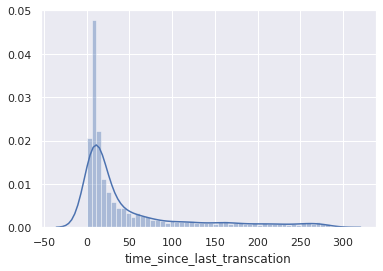

In [136]:
# distribution of days since last transcation
sns.distplot(df_after.time_since_last_transcation);

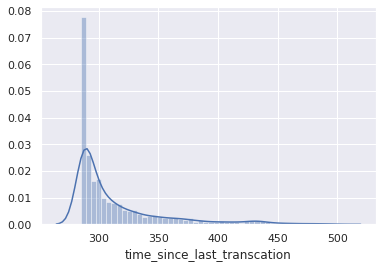

In [137]:
# distribution of days since last transcation
sns.distplot(df_before.time_since_last_transcation);

### 2 sample t-test

We can quickly check whether the two means are equal (hypothesis) or not equal (null hypothesis)

The results show us that the two means are indeed different

In [138]:
t, p = ttest_ind(df_before.time_since_last_transcation.values, df_after.time_since_last_transcation.values, equal_var=False)
print("t = " + str(t))
print("p = " + str(p))

t = 266.01644946134826
p = 0.0


### Conclusion

Looking at the users who were there before the experiment and received the notification, there doesnt seem to a decrease in the average time since their last transcation. Rather, the group mean appears to have gotten higher meaning that the campaign may not have been effective

In [139]:
#close connection
close_connection(connection)

PostgreSQL connection is closed
